## PyTorch Workflow Fundamentals

### Introduction to Pytorch workflow

In [1]:
what_were_covering = {1:'data (prepare and load)',
                      2:'build model',
                      3: 'fitting the model to data(training)',
                      4: 'making predicitions and evaluating a model (inference)',
                      5: 'saving and loading a model',
                      6: 'putting it all together'}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data(training)',
 4: 'making predicitions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check pytorch version
torch.__version__

'2.1.1'

#### 1. Data (preparing and loading)

Data can be anything in machine learning.
* Excel spreadsheet
* Images of anykind
* Videos
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

We'll use a linear regression formula to make a straight line with known parameters

In [3]:
# Create known paramaeters
weight = 0.7
bias = 0.3

# Create Data
start = 0
end = 1
step = 0.02

X = torch.arange(start,end, step).unsqueeze(dim=1) # "X" is capital represents a tensor
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

##### Splitting data into training and testing sets

In [5]:
# create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where data explorer's motto come in!
'Visualize, visualize, visualize!'

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels= y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     prediction=None):
    """
    Plots training data, test data and compares prediction.
    """
    plt.figure(figsize=(10,7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

    # Plot testing data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

    # Prediction
    if prediction is not None:
        plt.scatter(test_data, prediction, c='r', s=4, label='Predictions')
    
    # Show the legend
    plt.legend(prop={'size':14})

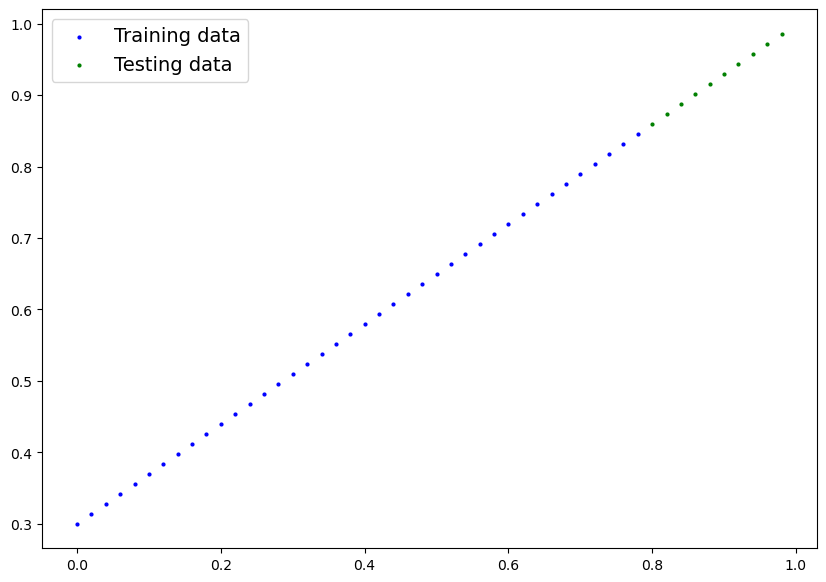

In [7]:
plot_predictions()

#### 2. Build model

First pytorch model

What are model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias used to create the data).

How does it do so?

Through two main algorithms:
1. Gradient Descent
2. Backpropagation

In [8]:
# Create linear regression model class
# nn.module: base class for all neural network modules

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                               requires_grad=True,
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                              requires_grad=True,
                                              dtype=torch.float))
        
    # Forward method to define the compuation in the model
    # '->': is a function annotation
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

##### PyTorch model building essentials

* **torch.nn** - contains all the building for computational graphs(a neural network can be considered a computational graphs)
* **torch.nn.Parameter** - what parameters should our model try and learn, often a Pytorch layer from torch.nn will set these for us
* **torch.nn.Module** - The base class for all neural network modules, if you subclass it, you should overwrite forward().
* **torch.optim** - this where the optimizers in pytorch live. will help the gradient descent.
* **def forward()** - all nn.module subclasses require you to overwrite forward(), this method defines what happens in the forward computation.

##### Checking the contents of our Pytorch model

Now we've created a model, lets see whats inside

We can check our models parametrs using `.parameters()`

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Checkout the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

##### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` and based on `X_test`

When we pass data through our model, it's going to run it through the `forward()` method.

In [11]:
# Make predictions with model
with torch.inference_mode(): # <= disables gradient descent and backend data
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

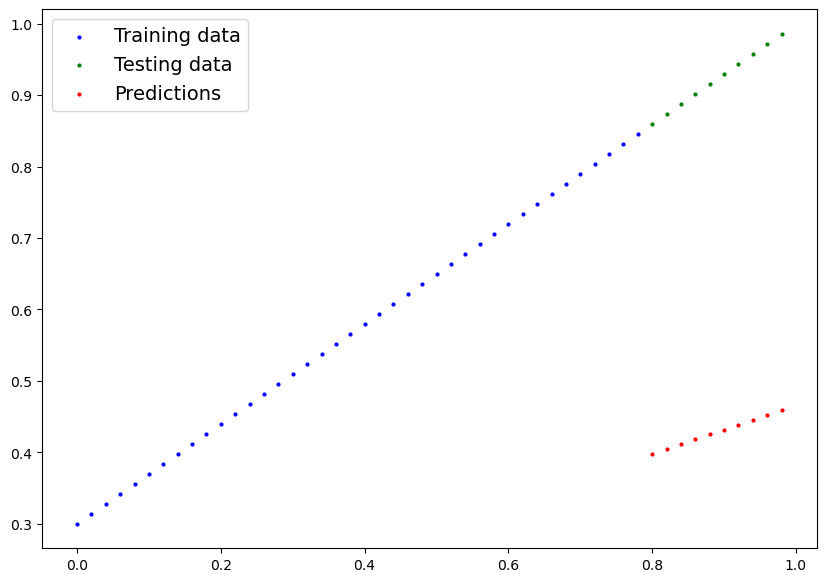

In [12]:
plot_predictions(prediction=y_preds)

#### 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of data.

One way to measure how poor or how wrong your models predictions are is to use a **loss function**.

* Note: Loss function may also be called cost function or criterion in different areas. For now, we are going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (i.e. weight & bias) to improve the loss function.
    * Inside the optimizers you'll often have to set two parameters:
        * params - the model parameters
        * lr - learning rate of the optimizer

And specifically for pytorch, we need:
* A training loop
* A testing loop

In [13]:
# Setup a loss function
loss_fn = nn.L1Loss()


# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0001) # lr = learning rate = one of the important hyperparameters (hyperparameters are parameters set by the researchers)

##### Building a training loop and testing loop in pytorch

A couple of things we need in a training loop:
1. Loop through the data
2. Forward pass (this involves data moving through our model's `forward()` functions) to make prediction on data - also called forward propagation
3. Calculate the loss (compare forward pass predictions to ground truth labels)
4. Optimizer zero grad
5. Loss backwards - move backword through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
6. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [14]:
# An epoch is one loop through the data... (epoch is a hyperparameters)
epochs = 1000

# Track different vlaues
epoch_count = []
train_loss_values = []
test_loss_values = []

# step 1. loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train() # training mode in pytorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimzier changes will acculmulate through the loop so.. we have to zero them above in step 3 for the next iteration of the loop

    # Testing
    model_0.eval() # turns off gradient tracking
    with torch.inference_mode():
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    
    # Prints what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')
        print(model_0.state_dict())


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.4944015145301819
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1289]))])
Epoch: 10 | Loss: 0.31172919273376465 | Test loss: 0.49305421113967896
OrderedDict([('weights', tensor([0.3371])), ('bias', tensor([0.1299]))])
Epoch: 20 | Loss: 0.31057703495025635 | Test loss: 0.4917070269584656
OrderedDict([('weights', tensor([0.3375])), ('bias', tensor([0.1309]))])
Epoch: 30 | Loss: 0.30942484736442566 | Test loss: 0.4903597831726074
OrderedDict([('weights', tensor([0.3379])), ('bias', tensor([0.1319]))])
Epoch: 40 | Loss: 0.30827268958091736 | Test loss: 0.48901262879371643
OrderedDict([('weights', tensor([0.3383])), ('bias', tensor([0.1329]))])
Epoch: 50 | Loss: 0.30712056159973145 | Test loss: 0.4876653552055359
OrderedDict([('weights', tensor([0.3387])), ('bias', tensor([0.1339]))])
Epoch: 60 | Loss: 0.30596840381622314 | Test loss: 0.4863181710243225
OrderedDict([('weights', tensor([0.3391])), ('bias', tensor([0.1349]))]

In [15]:
import numpy as np
np.array(torch.tensor(train_loss_values).detach().numpy())

array([0.31288138, 0.3117292 , 0.31057703, 0.30942485, 0.3082727 ,
       0.30712056, 0.3059684 , 0.30481625, 0.30366406, 0.3025119 ,
       0.3013597 , 0.30020756, 0.29905543, 0.29790324, 0.29675108,
       0.29559892, 0.29444677, 0.2932946 , 0.29214248, 0.2909903 ,
       0.28983814, 0.28868598, 0.28753382, 0.28638166, 0.2852295 ,
       0.28407735, 0.2829252 , 0.28177303, 0.28062087, 0.2794687 ,
       0.27831656, 0.27716437, 0.27601218, 0.27486005, 0.2737079 ,
       0.27255574, 0.27140355, 0.27025142, 0.26909924, 0.26794708,
       0.26679492, 0.26564276, 0.2644906 , 0.26333845, 0.2621863 ,
       0.2610341 , 0.25988194, 0.2587298 , 0.2575776 , 0.25642547,
       0.25527328, 0.25412115, 0.25296897, 0.25181684, 0.25066465,
       0.24951251, 0.24836035, 0.2472082 , 0.24605604, 0.24490388,
       0.24375172, 0.24259953, 0.24144737, 0.24029522, 0.23914304,
       0.2379909 , 0.23683874, 0.23568659, 0.23453441, 0.23338227,
       0.2322301 , 0.23107794, 0.22992578, 0.22877362, 0.22762

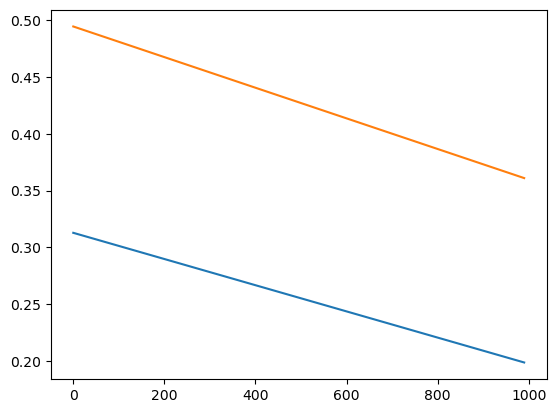

In [16]:
# Plot loss curve
'''
if converging: model is on right track
if diverging or not converging: model has problem
'''
plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).detach().numpy()), label='Train loss')
plt.plot(epoch_count, np.array(test_loss_values), label='Test Loss')

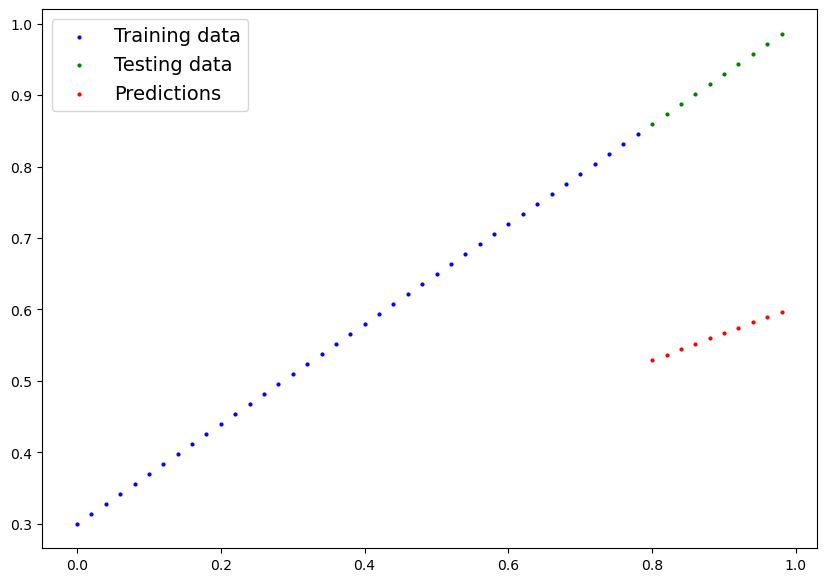

In [17]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)
plot_predictions(prediction=y_preds_new)

In [18]:
weight, bias

(0.7, 0.3)

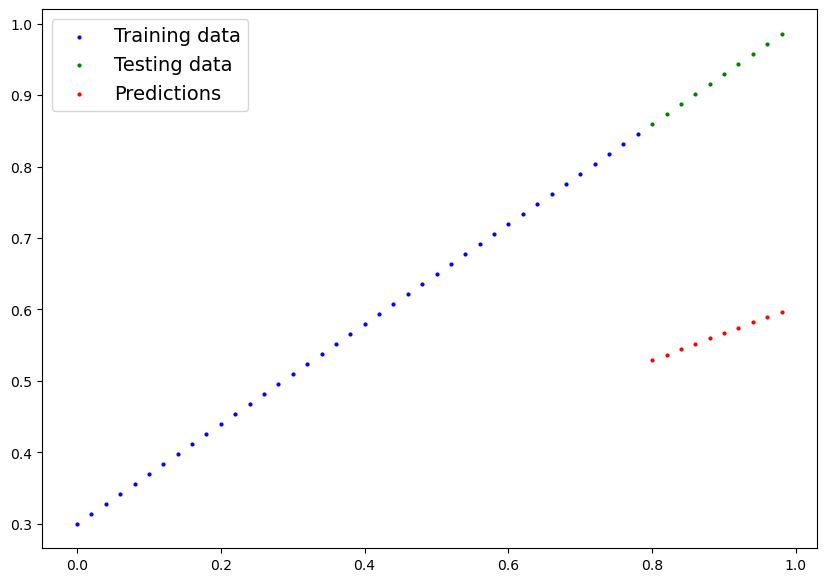

In [19]:
plot_predictions(prediction=y_preds_new)

### Saving a model in pytorch

There are three main methods you should about for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict` - this allows to laod a model's saved state dictionary

In [20]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_python_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

### Putting it all together
Apply what we learned

In [21]:
# Import libraries
import torch
import matplotlib.pyplot as plt
from torch import nn

# Torch version
print(f'Torch Version: {torch.__version__}')
    
# device agnostic code setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Device: {device}')


Torch Version: 2.1.1
Device: cuda


##### 6.1 Data
* Create some data
* Setting a `weights` and `bias`


In [25]:
# Setting up bias and weights
weight = 0.9
bias = 0.2

# Range of values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

# Prinst sample of the data X, y
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.2000],
         [0.2180],
         [0.2360],
         [0.2540],
         [0.2720],
         [0.2900],
         [0.3080],
         [0.3260],
         [0.3440],
         [0.3620]]))

In [26]:
# Splitting the data
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

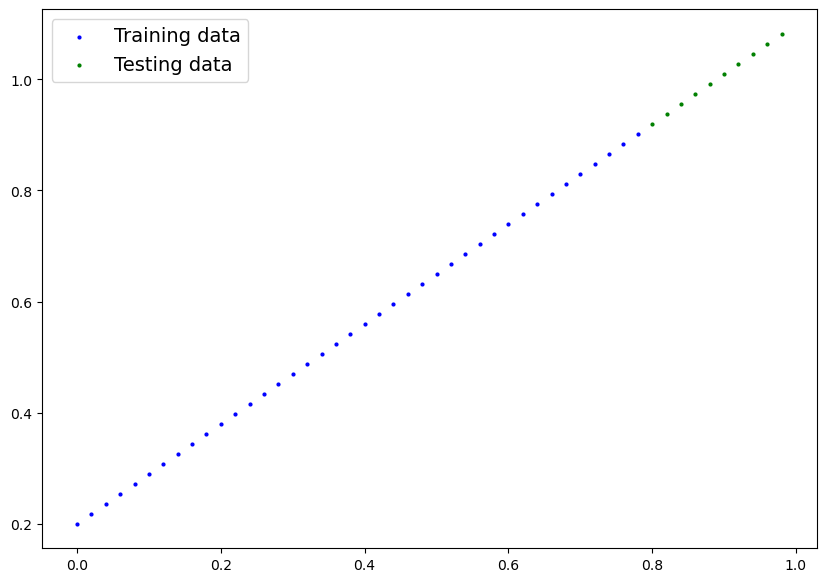

In [27]:
# Visualize the dataset

plot_predictions(X_train, y_train, X_test, y_test)

##### 6.2 Building a Pytoch linear model
We will be using the `nn.Linear()` function from pytorch.



In [47]:
class LinearregressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # using nn.linear(): in_features and out features are 1 becuase our dataset is only 1 dimension
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
    
    # Forward function
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearregressionModelV2()
model_1, model_1.state_dict()

(LinearregressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [48]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [49]:
# Set to gpu if available
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

##### 6.3 Training
* Building a testing and training loop
* Create loss function and an optimizer using `nn.L1Loss()` and `torch.optim.SGD()`.
* Set the **learning rate** to `0.01`

In [50]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [51]:
# Creating a training loop
torch.manual_seed(42)

# Set epoch
epochs = 1000

# Set data to 'cuda' device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
    # Training
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 5. loss calculation
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # Testing
    model_1.eval()

    # 1. Forward pass
    with torch.inference_mode(): # Remove torch variables
        test_pred = model_1(X_test)

        # 2. calculate the loss on testing
        test_loss = loss_fn(test_pred, y_test)

    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | train loss: {loss} | test loss: {test_loss}')

Epoch: 0 | train loss: 0.5771779417991638 | test loss: 0.4959762692451477


Epoch: 100 | train loss: 0.047114234417676926 | test loss: 0.10965748131275177
Epoch: 200 | train loss: 0.012773505412042141 | test loss: 0.028992921113967896
Epoch: 300 | train loss: 0.00448277872055769 | test loss: 0.005793172400444746
Epoch: 400 | train loss: 0.00448277872055769 | test loss: 0.005793172400444746
Epoch: 500 | train loss: 0.00448277872055769 | test loss: 0.005793172400444746
Epoch: 600 | train loss: 0.00448277872055769 | test loss: 0.005793172400444746
Epoch: 700 | train loss: 0.00448277872055769 | test loss: 0.005793172400444746
Epoch: 800 | train loss: 0.00448277872055769 | test loss: 0.005793172400444746
Epoch: 900 | train loss: 0.00448277872055769 | test loss: 0.005793172400444746


In [53]:
print(f'ideal bias: {bias} | ideal weight: {weight}')
print("Predicted bias and weights")
model_1.state_dict()

ideal bias: 0.2 | ideal weight: 0.9
Predicted bias and weights


OrderedDict([('linear_layer.weight', tensor([[0.8936]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.1980], device='cuda:0'))])

##### 6.3 Making predictions

In [57]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.9129],
        [0.9308],
        [0.9486],
        [0.9665],
        [0.9844],
        [1.0023],
        [1.0201],
        [1.0380],
        [1.0559],
        [1.0737]], device='cuda:0')

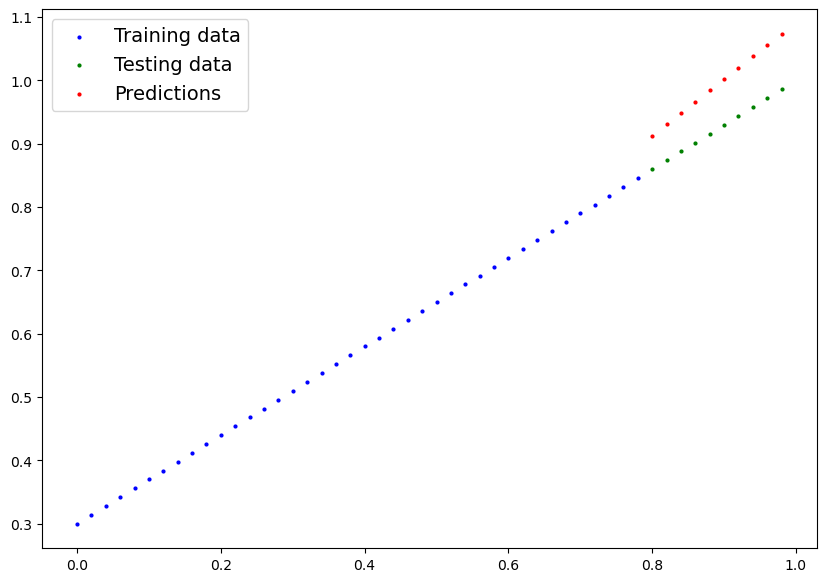

In [58]:
plot_predictions(prediction=y_preds.cpu())

##### 6.5 Saving and loading a model

In [60]:
from pathlib import Path

# 1. Create a model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '0.1_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model state dict {parameters}
print("saving")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

saving


In [61]:
### Loading model

# Initialize new model
loaded_model_1 = LinearregressionModelV2()

# Load state dict into the initialized model
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Change device to 'cuda' if available
loaded_model_1.to(device)

print(f"loaded model state dict: {loaded_model_1.state_dict()}")

loaded model state dict: OrderedDict([('linear_layer.weight', tensor([[0.8936]], device='cuda:0')), ('linear_layer.bias', tensor([0.1980], device='cuda:0'))])


In [63]:
# Evaluate loaded model
loaded_model_1.eval()

with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Extra-Curriculum
* Listen to The Unofficial PyTorch Optimization Loop Song (to help remember the steps in a PyTorch training/testing loop).
* Read What is torch.nn, really? by Jeremy Howard for a deeper understanding of how one of the most important modules in PyTorch works.
* Spend 10-minutes scrolling through and checking out the PyTorch documentation cheatsheet for all of the different PyTorch modules you might come across.
* Spend 10-minutes reading the loading and saving documentation on the PyTorch website to become more familiar with the different saving and loading options in PyTorch.
* Spend 1-2 hours read/watching the following for an overview of the internals of gradient descent and backpropagation, the two main algorithms that have been working in the background to help our model learn.
* Wikipedia page for gradient descent
* Gradient Descent Algorithm — a deep dive by Robert Kwiatkowski
* Gradient descent, how neural networks learn video by 3Blue1Brown
* What is backpropagation really doing? video by 3Blue1Brown
* Backpropagation Wikipedia Page